<a href="https://colab.research.google.com/github/DoItSon/JejuBoorim_pjt/blob/main/%EB%84%A4%EC%9D%B4%EB%B2%84%EB%A6%AC%EB%B7%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kiwipiepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 28.9 MB/s 
     |████████████████████████████████| 30.5 MB 1.3 MB/s 
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.14.0-py3-none-any.whl size=30560039 sha256=891531474bafc237841d9a4f0320c45d55e8dcbb6376458681dbe41c875b0c77
  Stored in directory: /root/.cache/pip/wheels/51/c4/8a/496d744b1307d34d63960f7124851a3447db2f744cb7eb2aeb
Successfully built kiwipiepy-model


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import random
import pandas as pd
import numpy as np
import os
import re

from kiwipiepy import Kiwi

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer
from sklearn.model_selection import train_test_split

import torch

from tqdm.auto import tqdm
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DATA_PATH = '/content/drive/MyDrive/오일/'

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [6]:
df_train_csv = pd.read_csv(f'{DATA_PATH}review_data.csv')
df = df_train_csv

In [7]:
df['score']

0      5
1      5
2      4
3      4
4      5
      ..
540    3
541    1
542    5
543    4
544    4
Name: score, Length: 545, dtype: int64

In [8]:
# train = train.reset_index().rename(columns={'index':'seq_id'})
# train

### 정답값이 지나치게 한쪽으로 치우쳐져 있다.
- K-Fold 사용하자!(앙상블 사용하여 모델을 robust하게)
- 데이터가 불균형하기 때문에 f1 score 사용
- 데이터의 양이 너무 적어서 사전학습 모델을 통한 전이학습이 성능이 좋을 것 같다. -> 학습하는데 시간이 오래걸리고, 기존에 사용해본 경험이 있어서 새로운 시도를 하고 싶다.

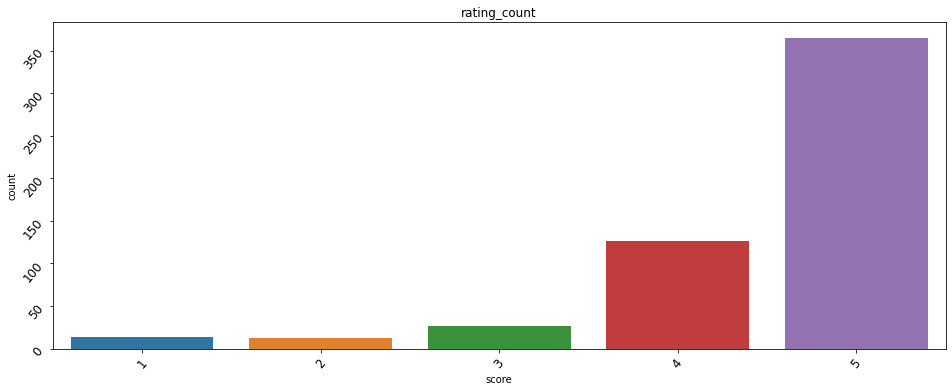

In [9]:
fig, ax = plt.subplots(1, figsize=(16, 6))

eda = sns.countplot(x = df['score'],
                data = df,
                )
eda.tick_params(labelsize=12)
eda.set_title('rating_count')
eda.set_ylabel('count')
eda.tick_params(rotation=50)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [10]:
def text_clearing(text): 
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    # 지정한 정규식에 해당하지 않은 것은 길이가 0인 문자열로 변환한다.
    result = hangul.sub('', text)
    return result

In [11]:
df["ko_review"] = df["review"].apply(lambda x : text_clearing(x))

In [12]:
df.drop("review", axis=1, inplace=True)
df

,score,y,ko_review
0,5,1,친절하시고 깔끔하고 좋았습니다
1,5,1,조용하고 고기도 굿
2,4,1,갈비탕과 냉면 육회비빔밥이 맛있습니다
3,4,1,대체적으로 만족하나와인의 구성이 살짝 아쉬움
4,5,1,고기도 맛있고 서비스는 더 최고입니다
...,...,...,...
540,3,0,추웟어요 고기 외에는 별로에요
541,1,0,고기질과 육전은 좋다다만 한우손님 돼지고기 손님을 차별한다돼지손님은 주차불가네이버예...
542,5,1,직접 구워주시고 진짜맛있음 반찬도 맛있음 직원분이 친절하게 잘해주시네요
543,4,1,친절하게 서빙해주시고 음식도 챙겨주셨어요 ㅎ


In [13]:
SEED = 42

In [14]:
train,test = train_test_split(df,random_state=SEED)
train.shape, test.shape

((408, 3), (137, 3))

In [15]:
train

,score,y,ko_review
167,4,1,예약이편해요
368,5,1,일단 질 좋은 생고기의 풍미가 최고였습니다개인적으로 목살은 그리 좋아하지 않았는데 ...
301,5,1,평일에 고기 먹기힘든 공부하는 아들과 일요회식을 하기로하고 교대역 근처 맛집을 찾던...
527,5,1,네이버 맛집들 잘 안 믿어서 그냥 속는셈치고 갔는데 웬열 진짜였네요 다음에 또 예...
382,5,1,직원분들 다 너무 친절하시고고기 잘 못 구워서 하남돼지집으로 간건데정말 맛있게 구워...
...,...,...,...
71,4,1,분위기도 좋고 컨셉도 신선하고 맛도 최고였는데 저희는 다 대식가라서 고기 익는거 기...
106,5,1,역시 맛집이라 정신없었지만맛은 확실하네요
270,5,1,조큼 비싸지만 맛있어요 주차도 편하고요
435,5,1,맛있고 분위기 좋습니다 잘 먹었습니다


In [16]:
test

,score,y,ko_review
316,4,1,고기 진짜 맛 있네요콜키지는 병당 입니다
77,5,1,정말 맛있네요
360,5,1,역시 대박 너무 맛있게 먹고 왔어요
90,5,1,한우곱창모듬 술이 술술 넘어가는 맛이였어요 지인들과 함께 갈만한 곳
493,4,1,비오는 금요일 저녁 방문했는데 예약도 잘되고 시설도 깔끔하고 고기도 맛나고 가격은 ...
...,...,...,...
172,5,1,갈비탕 된장찌개 맛나고 반찬 리필도 잘 해주시네요
124,5,1,이번엔 진꽃살을 먹어봤는데 진짜 살살녹아요 직원분이 알려주신방법대로 알려주신 소스...
388,4,1,돼지고기 인세트와 멸치국수 시켰어요양도 적당하고 맛있었습니다칵테일 서비스도 주시고담...
521,5,1,쾌적하고 깔끔한 곳입니다


In [17]:
target  = train['y'] # 정답

train  = train.drop(['score', 'y'], axis = 1) # 정답값 제외

test = test.drop(['score', 'y'], axis = 1) # 추론 데이터

train.shape,target.shape,test.shape

((408, 1), (408,), (137, 1))

In [18]:
# train = train.reset_index().rename(columns={'index':'seq_id'})
# test = test.reset_index().rename(columns={'index':'seq_id'})

In [19]:
# train.shape,target.shape,test.shape

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [21]:
kiwi = Kiwi()
kiwi.prepare()

In [22]:
lst = train["ko_review"].tolist()
gen = kiwi.analyze(lst)
train_overview = []

for tokens in tqdm(gen,total=len(lst)):
    token = [ token.form for token in tokens[0][0] if token.tag[0] in "NV" ]
    train_overview.append(" ".join(token))

lst = test["ko_review"].tolist()
gen = kiwi.analyze(lst)
test_overview = []
for tokens in tqdm(gen,total=len(lst)):
    token = [ token.form for token in tokens[0][0] if token.tag[0] in "NV" ]
    test_overview.append(" ".join(token))

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

In [23]:
model_name = "klue/roberta-large"

In [24]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.7 MB/s 
     |████████████████████████████████| 182 kB 67.2 MB/s 
     |████████████████████████████████| 7.6 MB 49.3 MB/s 


In [25]:
from transformers import AutoTokenizer, AutoModel
from transformers import AdamW

tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/752k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [26]:
train_overview = np.array(train_overview)
test_overview = np.array(test_overview)
target = target.to_numpy().reshape(-1,1)

In [27]:
token = tokenizer(train_overview[0], add_special_tokens=True,padding="max_length", truncation=True)
token

{'input_ids': [0, 6297, 6978, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [28]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self ,tokenizer , x, y = None ): 
        self.tokenizer = tokenizer
        self.x = x
        self.y = y
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, idx): 
        item = {}
        item["x"] = self.__tokenizer(self.x[idx]) 
        if self.y is not None:
            item["y"] = torch.tensor(self.y[idx])
        return item
    def __tokenizer(self,text):
        inputs = self.tokenizer(text, add_special_tokens=True,padding="max_length", truncation=True)
        for k, v in inputs.items(): 
            inputs[k] = torch.LongTensor(v) 
        return inputs

In [29]:
dt = MyDataset(tokenizer,train_overview,target)
dl = torch.utils.data.DataLoader(dt, batch_size=2,shuffle=False) 
batch = next(iter(dl))
batch

{'x': {'input_ids': tensor([[   0, 6297, 6978,  ...,    1,    1,    1],
         [   0, 1586, 1560,  ...,    1,    1,    1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}, 'y': tensor([[1],
         [1]])}

In [30]:
model = AutoModel.from_pretrained(model_name)

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it f

In [31]:
batch["x"].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [32]:
outputs = model(**batch["x"])
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [33]:
model.config.hidden_size

1024

In [34]:
class Net(torch.nn.Module):
    def __init__(self, model_name): 
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.output_layer = torch.nn.Linear(self.model.config.hidden_size, 1)
        
    def forward(self, x):
        x = self.model(**x) 
        x = self.output_layer(x[1])
        # print(x.shape)
        return x

In [35]:
def train_loop(dataloader,model,loss_fn,optimizer,device):
    epoch_loss = 0 
    model.train() 
    for batch in tqdm(dataloader): 
        pred = model(batch["x"].to(device)) 
        loss = loss_fn(pred.to(torch.float32), batch["y"].to(device).to(torch.float32))
        
        optimizer.zero_grad() 
        loss.backward()  
        optimizer.step() 
        
        epoch_loss += loss.item() 

    epoch_loss /= len(dataloader) 

    return epoch_loss 

In [36]:
@torch.no_grad() 
def test_loop(dataloader,model,loss_fn,device): 
    epoch_loss = 0
    model.eval() 
  
    pred_list = []
    sigmoid = torch.nn.Sigmoid() # dim=1

    for batch in tqdm(dataloader):
        
        pred = model(batch["x"].to(device))
        if batch.get("y") is not None: 
            loss = loss_fn(pred, batch["y"].to(device).to(torch.float32))
            epoch_loss += loss.item()
        
        pred = sigmoid(pred)
        pred = pred.to("cpu").numpy() 
        pred_list.append(pred)

    epoch_loss /= len(dataloader)

    pred = np.concatenate(pred_list) 
    return epoch_loss , pred 

In [37]:
n_splits = 5
batch_size = 8
epochs = 100
loss_fn = torch.nn.BCEWithLogitsLoss()

In [38]:
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
cv = KFold(n_splits=n_splits,shuffle=True, random_state=SEED)

In [39]:
import torch, gc # 남아있는 캐시 지우기
gc.collect()
torch.cuda.empty_cache()

In [40]:
is_holdout = False
seed_everything(SEED)
best_score_list = []

for i,(tri,vai) in enumerate(cv.split(train_overview)):
    
    model = Net(model_name).to(device)
    optimizer = torch.optim.AdamW(model.parameters(),lr=0.00002) # 0.00002

    train_dt = MyDataset(tokenizer,train_overview[tri],target[tri])
    valid_dt = MyDataset(tokenizer,train_overview[vai],target[vai])
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size,shuffle=False)

    best_score = 0
    patience = 0

    for epoch in range(epochs):
        
        train_loss = train_loop(train_dl, model, loss_fn,optimizer,device )
        valid_loss , pred = test_loop(valid_dl, model, loss_fn,device  )
        
        pred = np.argmax(pred, axis=1) 
        true = target[vai] 
        score = f1_score(true, pred , average="weighted")
        print(train_loss,valid_loss,score)
        patience += 1
        if best_score < score:
            patience = 0
            best_score = score
            torch.save(model.state_dict(),f"{DATA_PATH}model_{i}.pth")

        if patience == 2:
            break
    print(f"Fold ({i}), BEST F1: {best_score}")
    best_score_list.append(best_score)

    torch.cuda.empty_cache()

    if is_holdout:
        break

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it f

  0%|          | 0/41 [00:00<?, ?it/s]

OutOfMemoryError: ignored